# Estimation des paramètres

In [1]:
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import re
import sklearn
import random
import textdistance

from spacy.vocab               import Vocab
from spacy.language            import Language
from spacy.tokens              import Token
from spacymoji                 import Emoji
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.model_selection import train_test_split
from sklearn                   import metrics


In [2]:
nlp = spacy.load("en_core_web_sm")

@Language.component("hashtag")
def hashtag_pipe(
    doc: spacy.tokens.Doc
) -> spacy.tokens.Doc:
    """
    A spaCy pipeline component that merges tokens of the form #word into a single token.

    Parameters
    ----------
    doc : spacy.tokens.Doc
        The input spaCy Doc object to process.

    Returns
    -------
    spacy.tokens.Doc
        The processed spaCy Doc object with hashtags merged into a single token.
    """
    len_doc = -1
    for token in doc:
        len_doc=len_doc+1
    merged_hashtag = False
    while True:
        for token in doc:
            if token.text == '#':
                if(token.head is not None and token.i!=len_doc):
                    start_index = token.i
                    end_index = start_index + 1
                    with doc.retokenize() as retokenizer:
                        retokenizer.merge(doc[start_index:end_index+1])
                        merged_hashtag = True
                        break
        if not merged_hashtag:
            break
        merged_hashtag = False
    return doc

nlp.add_pipe("emoji", first=True)
nlp.add_pipe("hashtag", first=True)
Token.set_extension("is_hashtag", getter=lambda token: token.text[0] in ("#"), force=True)

Importation du corpus.

In [3]:
corpus = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel10k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus["language"] == 'en'
corpus = corpus.loc[mask]
chanel = corpus['text'].tolist()
publication_time_chanel = corpus['publication_time'].tolist()

print(f"# documents in corpus: {len(chanel)}")

# documents in corpus: 1802


### Estimation du seuil de la distance de Levenshtein normalisée

In [41]:
corpus_test = corpus[['text','publication_time']].sample(n= 100, random_state = 42)

In [5]:
def nb_per_thresholds(
    corus   : pd.DataFrame,
    )-> tuple[list,list]:
    """
    Return the number of post after deleting the posts with similar text and all the threshholds tested.

    Parameters
    ----------
    corus   : pd.DataFrame
    """
    nb_remaing_posts = []
    thresholds = np.linspace(0,1,20)
    dist = textdistance.levenshtein.normalized_distance
    for limit in thresholds:
        nb_remaing_posts.append(len(utilities.delete_duplicates(corpus_test['text'].tolist(),corpus_test['publication_time'].tolist(),limit,dist)))
    return thresholds,nb_remaing_posts
        

In [80]:
x,y = nb_per_thresholds(corpus_test)


In [81]:
y = [i*100/max(y) for i in y]

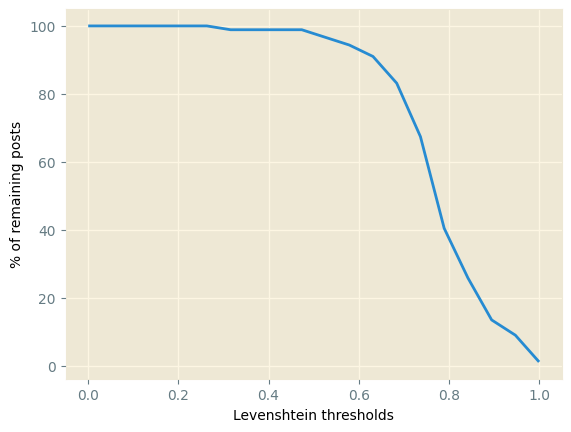

In [86]:
import matplotlib.pyplot as plt

fig = plt.figure()
with plt.style.context('Solarize_Light2'):
    plt.plot(x, y)
    plt.xlabel('Levenshtein thresholds')
    plt.ylabel('% of remaining posts')

In [43]:
def get_duplicates(
    corpus: list, 
    limit: float, 
    method: callable
    ):
    originals = []
    copies = []
    t = [utilities.clean_hashtag(s).strip() for s in corpus]
    distance = method #initialisiation de levenshtein avec la distance normalisée.
    i = 0
    r = len(t)
    while(i<r):
        r = len(t)
        j=i+1
        while(j<r):
            if(distance(t[i],t[j]) <= limit ): # Si la distance entre les deux élemens de la liste inf à seuil
                originals.append(t[i])
                copies.append([t[j]])
                break
            j+=1
        i+=1
    return pd.DataFrame({'originals' : originals , 'copies' : copies})

In [44]:
dist = textdistance.levenshtein.normalized_distance
originlas_copies = get_duplicates(corpus['text'].sample(n= 50, random_state = 42).tolist(),0.6,dist)

In [49]:
corpus_test.to_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/test_levenshtein.csv")

In [45]:
originlas_copies

,originals,copies
0,,[]
1,és,[ès]
2,ès,[és]


In [7]:
def get_duplicates_per_thresholds():
    list_duplicates_per_thresholds = []
    list_thresholds = np.linspace(0.4,1,13)
    dist = textdistance.levenshtein.normalized_distance
    for thresholds in list_thresholds:
        list_duplicates_per_thresholds.append(get_duplicates(corpus['text'].sample(n= 50, random_state = 10).tolist(),thresholds,dist))
    return pd.DataFrame({'threshold' : list_thresholds , 'duplicates' : list_duplicates_per_thresholds})

In [9]:
df_dup_per_thesh = get_duplicates_per_thresholds()

In [11]:
df_dup_per_thesh

,threshold,duplicates
0,0.40,ori...
1,0.45,ori...
2,0.50,ori...
3,0.55,ori...
4,0.60,ori...
5,0.65,ori...
6,0.70,or...
7,0.75,or...
8,0.80,or...
9,0.85,or...


In [35]:
df_dup_per_thesh['duplicates'][4]

,originals,copies
0,"If you need my products, please add my whatsap...","[If you need my products, please add my whatsa..."
1,"Wholesale (shoes, clothes, hats, belts, etc.) ...","[Wholesale (shoes, clothes, hats, belts, etc.)..."
2,We are mainly engaged in various brands of sho...,[We are mainly engaged in various brands of sh...
3,,[]
4,"Hello friend, there are many products you need...","[Hello friend, there are many products you nee..."


### Optimisation paramètres de l'arbre de décision

In [4]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_new.xlsx')
chanel_junk_valid_new = chanel_junk_valid_new[['text','is_junk']].dropna()
chanel_junk_valid_new['has_URL'] = utilities.get_presence_of_URL(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_phone_number'] = utilities.get_presence_of_phone_numbers(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_currency_symbol'] = utilities.get_presence_of_currency_symbol(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['word_ratio'] = utilities.get_word_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['caps_ratio'] = utilities.get_caps_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp)
chanel_junk_valid_new['norm_punct'] = utilities.get_normalized_nb_punct(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'emoji',nlp = nlp, top= 3))
chanel_all_features = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'hashtag', nlp = nlp, top= 3))
X_train, X_test, y_train, y_test = train_test_split(chanel_all_features.dropna().drop(['text','is_junk'],axis=1), chanel_all_features.dropna()['is_junk'], test_size=0.30, random_state=42)

Arbre 1 : 

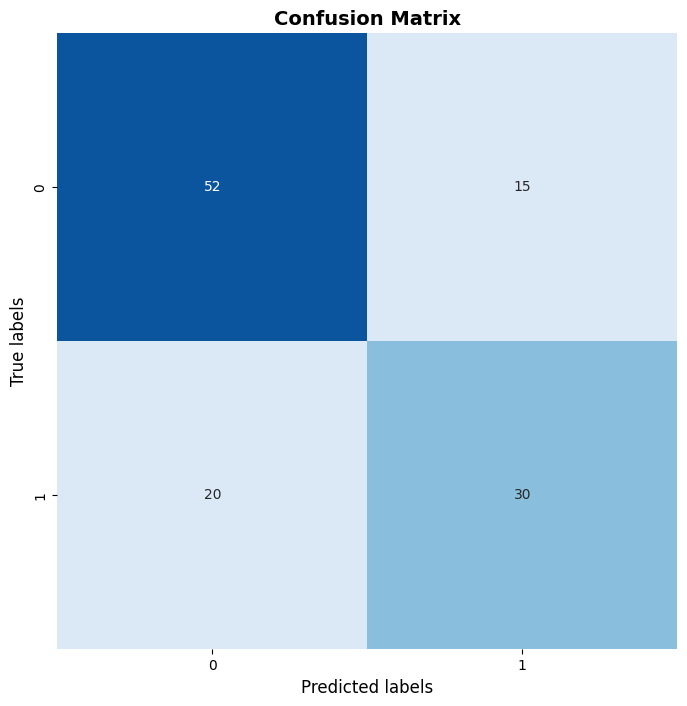

AUC : 0.6880597014925374
Accuracy score : 0.7008547008547008


In [42]:
tree1 = DecisionTreeClassifier(criterion = 'gini')
tree1.fit(X_train,y_train)
y_pred = tree1.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 2

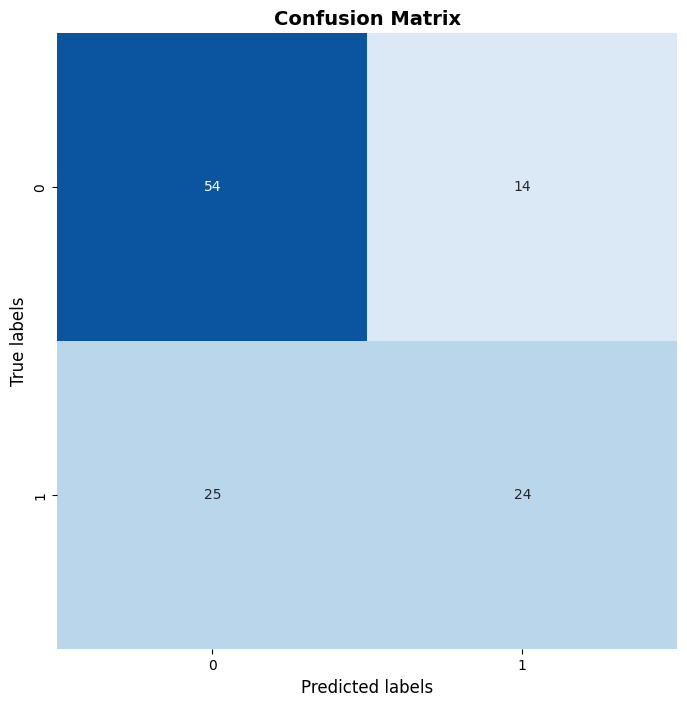

AUC : 0.6419567827130853
Accuracy score : 0.6666666666666666


In [61]:
tree2 = DecisionTreeClassifier(criterion = 'entropy')
tree2.fit(X_train,y_train)
y_pred = tree2.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 3

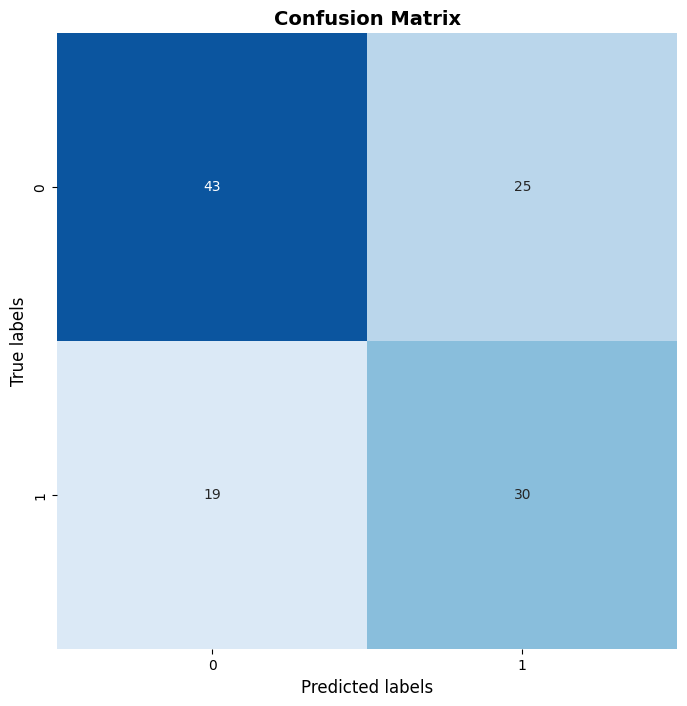

AUC : 0.6222989195678271
Accuracy score : 0.6239316239316239


In [67]:
tree3 = DecisionTreeClassifier(criterion = 'entropy',class_weight = "balanced")
tree3.fit(X_train,y_train)
y_pred = tree3.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 4

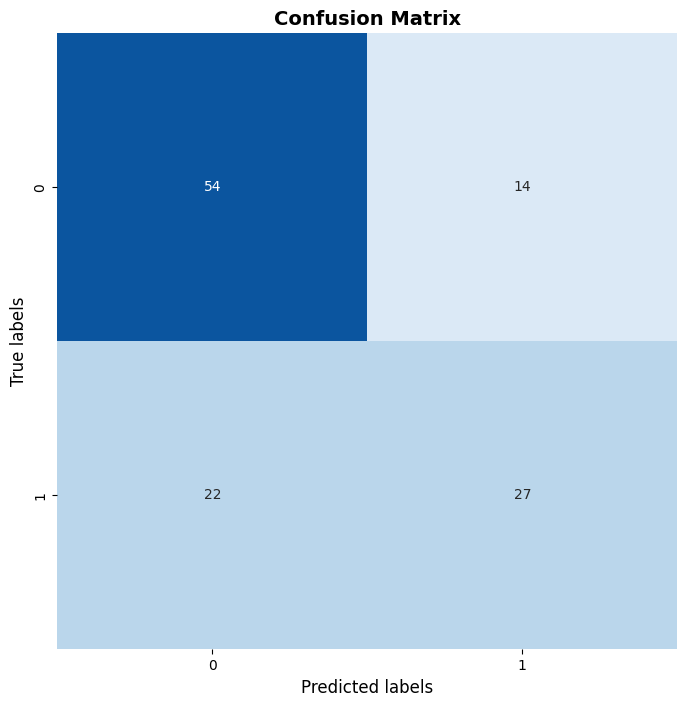

AUC : 0.6725690276110444
Accuracy score : 0.6923076923076923


In [37]:
tree4 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10)
tree4.fit(X_train,y_train)
y_pred = tree4.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 5

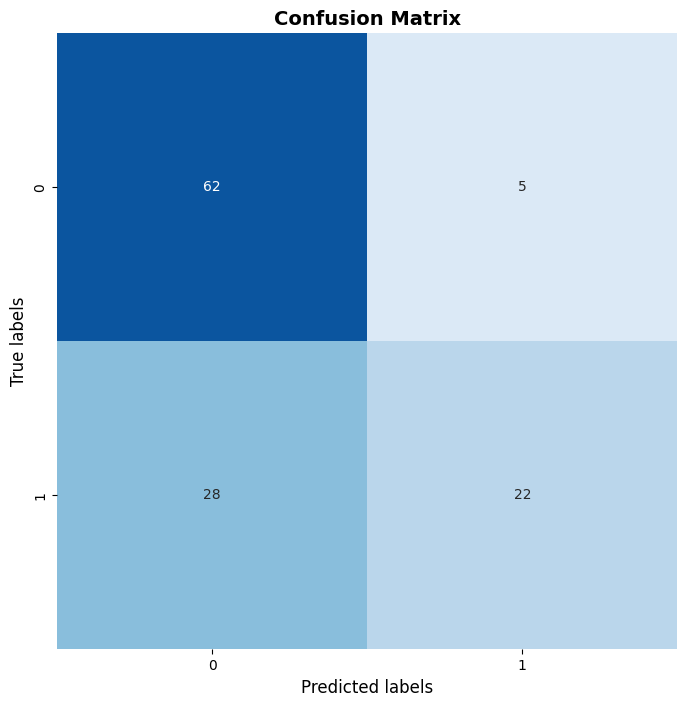

AUC : 0.6826865671641791
Accuracy score : 0.717948717948718


(0.7518518518518518, 0.6826865671641791, 0.6806187443130118, None)

In [55]:
tree5 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 13, ccp_alpha =  0.026, min_samples_leaf = 5, max_features = 7, min_samples_split = 13)
tree5.fit(X_train,y_train)
y_pred = tree5.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")
precision_recall_fscore_support(y_test, y_pred, average='macro')


### Combinaison des trois paramètres 

Gridsearch

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = {  'criterion': ['entropy'],
                'max_depth' : np.linspace(5,15,8, dtype= int),
                'ccp_alpha' : np.linspace(0.01,0.040,16),
                'min_samples_leaf' : np.linspace(1,15,7,dtype= int),
                'max_features' : np.linspace(5,15,6,dtype= int),
                'min_samples_split' : np.linspace(5,15,6,dtype= int)
                }  
   
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc' ,refit = True, verbose = 3,n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 32256 candidates, totalling 161280 fits
{'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 13, 'max_features': 7, 'min_samples_leaf': 5, 'min_samples_split': 11}


Optimisaiton ccp

In [45]:
def optimize_ccp_alpha(X_train,X_test,y_train,y_test):    
    list_ccp_alpha = np.linspace(0.01,0.040,31)
    list_prec = []
    for ccp in list_ccp_alpha:
        tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 13, ccp_alpha =  ccp, min_samples_leaf = 5, max_features = 7, min_samples_split = 13)
        tree.fit(X_train,y_train)
        y_pred = tree.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        list_prec.append(confusion_matrix(y_test, y_pred)[0][0]/(confusion_matrix(y_test, y_pred)[0][1]+confusion_matrix(y_test, y_pred)[0][0]))
    return list_ccp_alpha,list_prec

In [46]:
ccp,list_prec = optimize_ccp_alpha(X_train,X_test,y_train,y_test)

In [47]:
print(f"ccp : {ccp}\nliste precision : {list_prec}")

ccp : [0.01  0.011 0.012 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021
 0.022 0.023 0.024 0.025 0.026 0.027 0.028 0.029 0.03  0.031 0.032 0.033
 0.034 0.035 0.036 0.037 0.038 0.039 0.04 ]
liste precision : [0.8507462686567164, 0.835820895522388, 0.9104477611940298, 0.8656716417910447, 0.8656716417910447, 0.7761194029850746, 0.9253731343283582, 0.8507462686567164, 0.8507462686567164, 0.9253731343283582, 0.9253731343283582, 0.9253731343283582, 0.9253731343283582, 0.9402985074626866, 0.9402985074626866, 0.9402985074626866, 0.9402985074626866, 0.9253731343283582, 0.9402985074626866, 0.9253731343283582, 0.9253731343283582, 0.9253731343283582, 0.9402985074626866, 0.9104477611940298, 0.9253731343283582, 0.9402985074626866, 0.9402985074626866, 0.9253731343283582, 0.9402985074626866, 0.9402985074626866, 0.9402985074626866]


In [48]:
ccp[list_prec==max(list_prec)]

array([0.023, 0.024, 0.025, 0.026, 0.028, 0.032, 0.035, 0.036, 0.038,
       0.039, 0.04 ])

Final tree

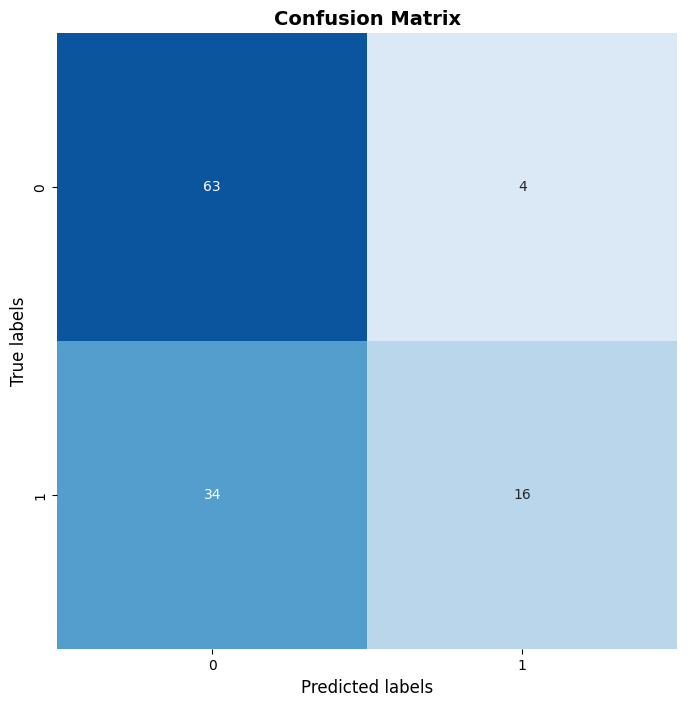

AUC : 0.6301492537313433
Accuracy score : 0.6752136752136753


In [53]:
tree_f = DecisionTreeClassifier(criterion = 'entropy', max_depth = 9, ccp_alpha =  0.026, min_samples_leaf = 3, max_features = 5, min_samples_split = 11)
tree_f.fit(X_train,y_train)
y_pred = tree_f.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Affichage arbre

[Text(0.5, 0.9, 'word_ratio <= 0.975\nentropy = 0.978\nsamples = 271\nvalue = [159, 112]\nclass = not junk'),
 Text(0.3333333333333333, 0.7, 'entropy = 0.734\nsamples = 34\nvalue = [7, 27]\nclass = junk'),
 Text(0.6666666666666666, 0.7, 'norm_punct <= 0.137\nentropy = 0.942\nsamples = 237\nvalue = [152, 85]\nclass = not junk'),
 Text(0.5, 0.5, '❤ <= 0.5\nentropy = 0.84\nsamples = 134\nvalue = [98, 36]\nclass = not junk'),
 Text(0.3333333333333333, 0.3, 'has_phone_number <= 0.5\nentropy = 0.808\nsamples = 129\nvalue = [97, 32]\nclass = not junk'),
 Text(0.16666666666666666, 0.1, 'entropy = 0.744\nsamples = 123\nvalue = [97, 26]\nclass = not junk'),
 Text(0.5, 0.1, 'entropy = 0.0\nsamples = 6\nvalue = [0, 6]\nclass = junk'),
 Text(0.6666666666666666, 0.3, 'entropy = 0.722\nsamples = 5\nvalue = [1, 4]\nclass = junk'),
 Text(0.8333333333333334, 0.5, 'entropy = 0.998\nsamples = 103\nvalue = [54, 49]\nclass = not junk')]

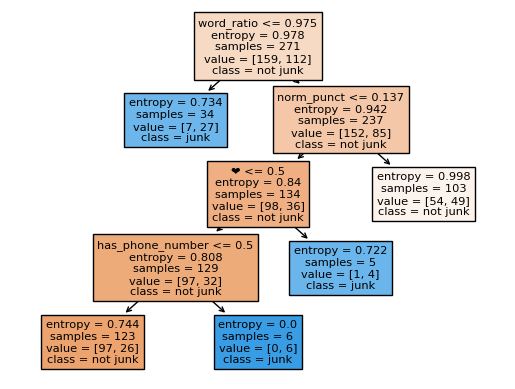

In [54]:
sklearn.tree.plot_tree(tree_f,feature_names = X_train.columns, class_names = ['not junk','junk'], filled = True)